## Imports

In [4]:
import numpy as np
import cv2
import mediapipe as mp
import math as m
import matplotlib.pyplot as plt  

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [6]:
blue = (255, 127, 0)
red = (50, 50, 255)
green = (127, 255, 0)
dark_blue = (127, 20, 0)
light_green = (127, 233, 100)
yellow = (0, 255, 255)
pink = (255, 0, 255)

def calculate_angle(a,b,c):
    a = np.array(a)
    b = np.array(b) 
    c = np.array(c) 
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    if angle >180.0:
        angle = 360-angle
    return angle 

def findDistance(x1, y1, x2, y2):
    dist = m.sqrt((x2-x1)**2+(y2-y1)**2)
    return dist

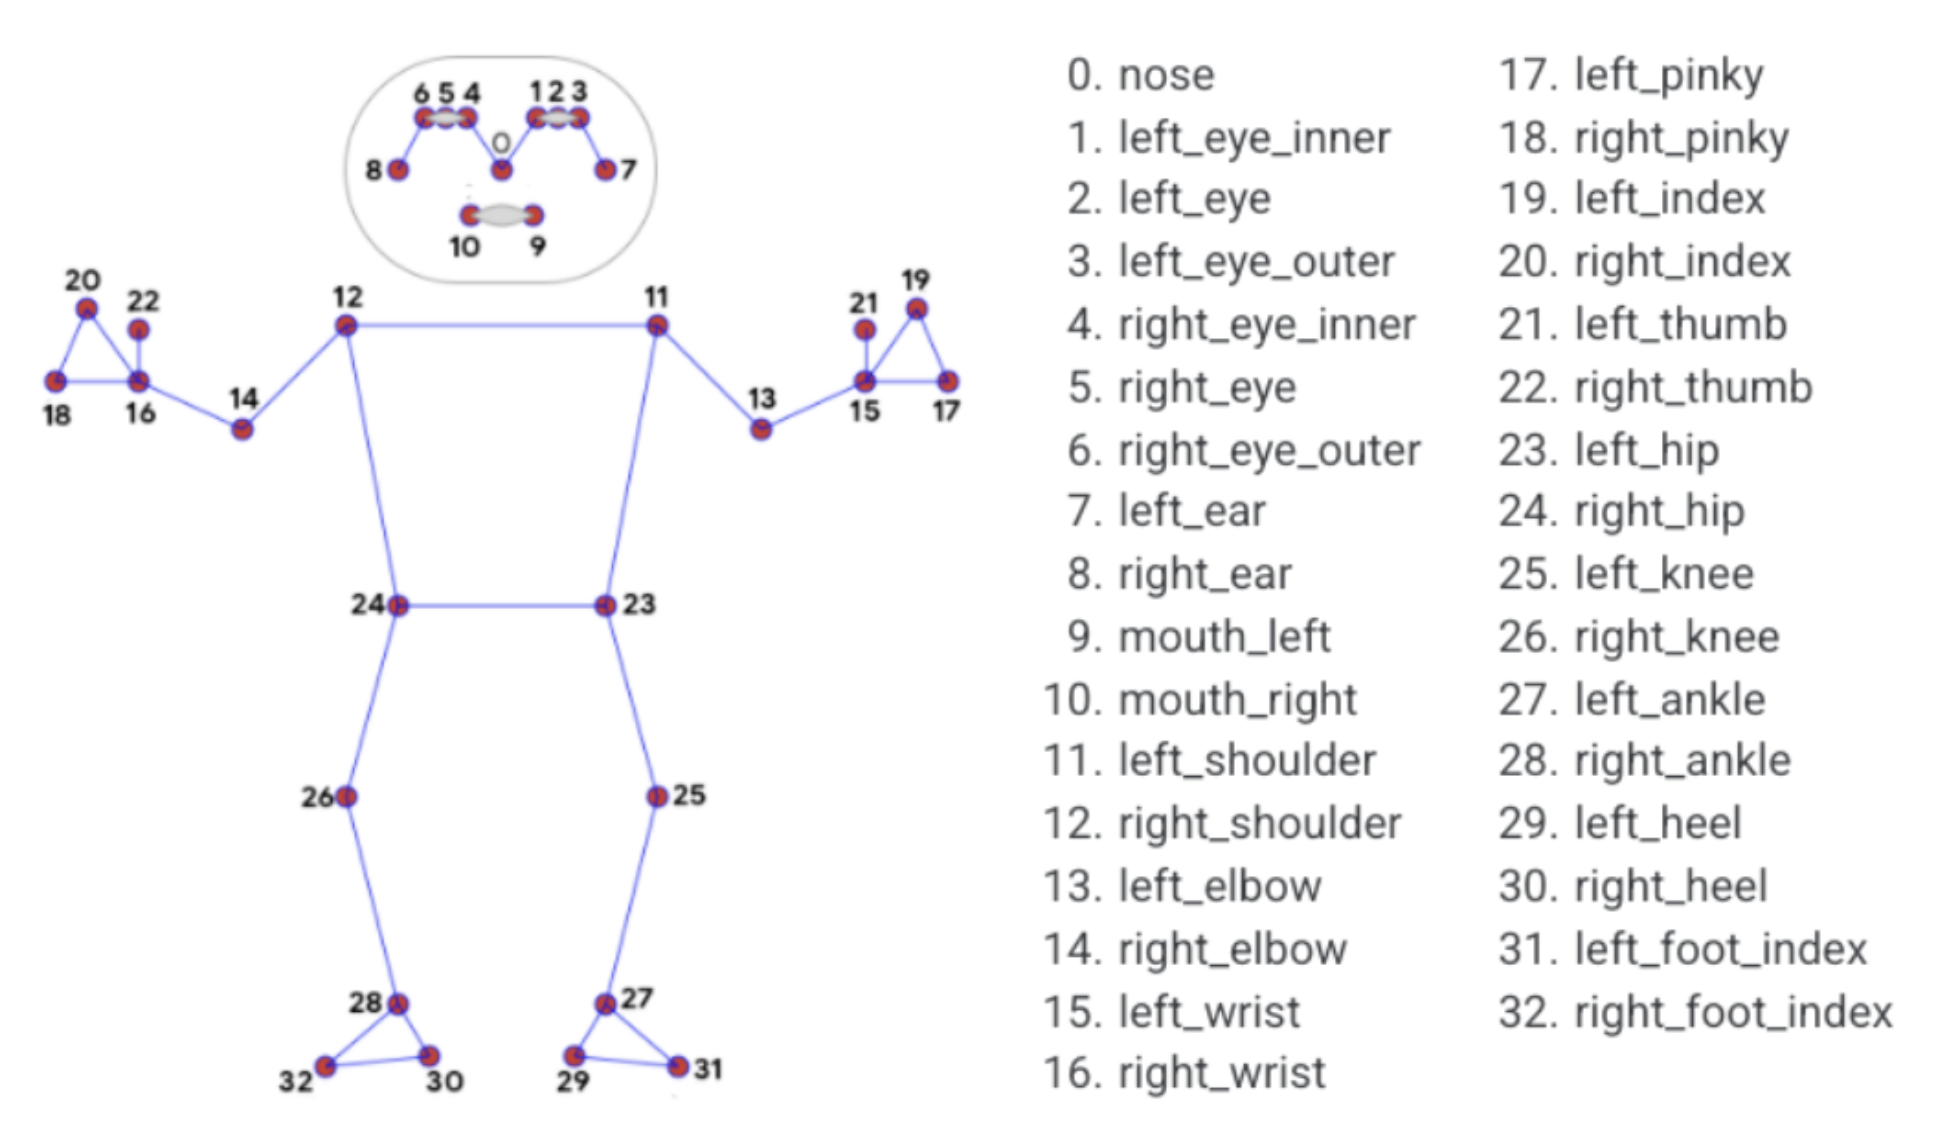

## Main

In [13]:
state = 'GOOD POSE'
cap = cv2.VideoCapture(0)   

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read() 
        if ret:
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False 
            results = pose.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
            try:
                landmarks = results.pose_landmarks.landmark 

                l_ear = [landmarks[mp_pose.PoseLandmark.LEFT_EAR.value].x,landmarks[mp_pose.PoseLandmark.LEFT_EAR.value].y]  
                r_ear = [landmarks[mp_pose.PoseLandmark.RIGHT_EAR.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_EAR.value].y]
                left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
                right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]

                left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]  
                r_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
                
                right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
                right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y] 

                left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
                left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y] 

                l_angle = calculate_angle(left_shoulder, left_hip, left_knee)
                r_angle = calculate_angle(r_shoulder, right_hip, right_knee) 
                neck_angle = calculate_angle(l_ear, left_shoulder, left_elbow)
                neck_angle_r = calculate_angle(r_ear, r_shoulder, right_elbow)
                offset = findDistance(left_shoulder[0], left_shoulder[1], r_shoulder[0], r_shoulder[1])
                height, width, channels = image.shape

                if offset < 100:
                    cv2.putText(image, str(int(offset)) + ' Aligned', (width - 150, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, green, 2)
                else:
                    cv2.putText(image, str(int(offset)) + ' Not Aligned', (width - 150, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, red, 2)

                cv2.putText(image, str(l_angle), 
                            tuple(np.multiply(left_hip, [width, height]).astype(int)), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                    )

                cv2.putText(image, str(r_angle), 
                            tuple(np.multiply(right_hip, [width, height]).astype(int)), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                    )  
                
                cv2.putText(image, str(neck_angle), 
                            tuple(np.multiply(left_shoulder, [width, height]).astype(int)), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                    )  
                cv2.putText(image, str(neck_angle_r), 
                            tuple(np.multiply(r_shoulder, [width, height]).astype(int)), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                    )                  
                
                if l_angle < 120 and r_angle < 120:
                    state = 'BAD POSE'
                    if neck_angle<150 and neck_angle_r<150:
                        state = 'BAD POSE'
                    else:
                        state = 'GOOD POSE'
                else:
                    state = 'GOOD POSE'
                    if neck_angle<150 and neck_angle_r<150:
                        state = 'BAD POSE'
                    else:
                        state = 'GOOD POSE'


            except:
                pass
            
            cv2.rectangle(image, (0, 0), (325, 73), (245, 117, 16), -1)  
            cv2.rectangle(image, (430, 0), (250, 73), (245, 117, 16), -1)
            
            cv2.putText(image, 'STATE', (25,12), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, state, 
                        (20,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
            
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                    mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                    )               
            
            cv2.imshow('Mediapipe Feed', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()